In [1]:
import pennylane as qml # 일반적으로 qml이란 이름으로 가져옵니다. Quantum Machine Learning의 약자입니다.
import numpy as np
import torch

In [2]:
dev = qml.device("default.qubit", wires=4) # device를 정의합니다.

@qml.qnode(dev)
def circuit():
    qml.H(0)
    qml.CNOT([0, 1])
    qml.H(2)
    qml.H(3)
    qml.S(3)
    qml.S(3)
    qml.H(3)
    qml.CNOT([2, 3])
    return qml.probs()

(<Figure size 800x500 with 1 Axes>, <Axes: >)

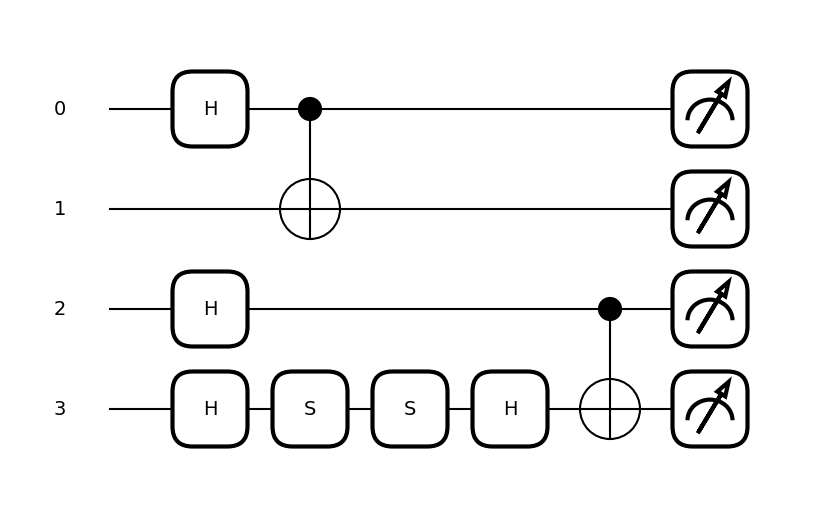

In [3]:
qml.draw_mpl(circuit)()

In [4]:
circuit()

array([0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.25, 0.25, 0.  ])

In [5]:
@qml.qnode(dev)
def circuit2():
    qml.H(0)
    qml.CNOT([0, 1])
    qml.H(2)
    qml.H(3)
    qml.S(3)
    qml.S(3)
    qml.H(3)
    qml.CNOT([2, 3])

    qml.CNOT([1, 2])
    qml.H(1)

    return qml.probs()

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

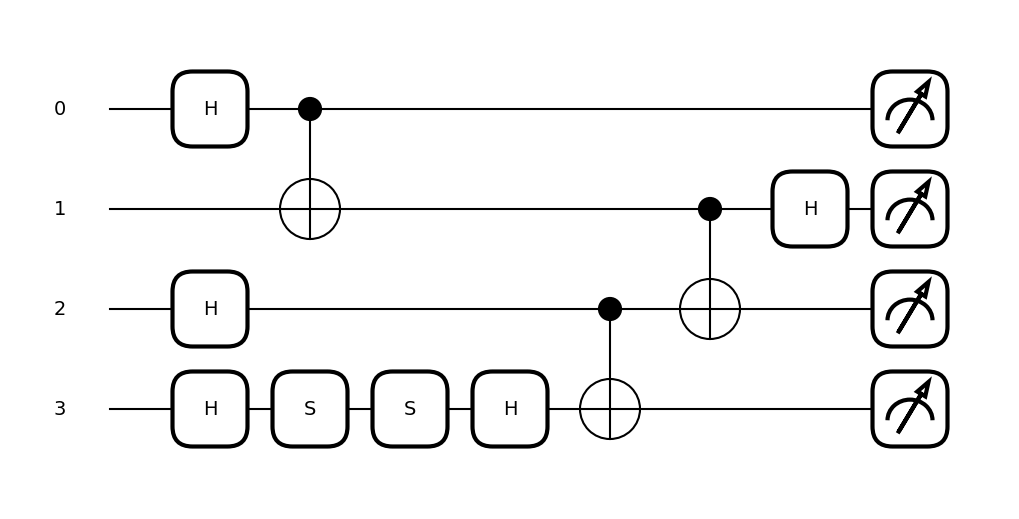

In [6]:
qml.draw_mpl(circuit2)()

In [7]:
circuit2()

array([0.   , 0.125, 0.125, 0.   , 0.   , 0.125, 0.125, 0.   , 0.125,
       0.   , 0.   , 0.125, 0.125, 0.   , 0.   , 0.125])

In [8]:
@qml.qnode(dev)
def noiseless_circuit():
    qml.H(0)
    qml.CNOT([0, 1])
    qml.H(2)
    qml.H(3)
    qml.S(3)
    qml.S(3)
    qml.H(3)
    qml.CNOT([2, 3])

    qml.CNOT([1, 2])
    qml.H(1)

    return qml.state()

In [9]:
def noise_after(w, p_dep, gamma, lam):
    qml.DepolarizingChannel(p_dep, wires=w)
    qml.AmplitudeDamping(gamma, wires=w)
    qml.PhaseDamping(lam, wires=w)

@qml.qnode(qml.device("default.mixed", wires=4, shots=None))
def noisy_circuit(p_dep = 0, gamma = 0, lam = 0):
    qml.H(0);        noise_after(0, p_dep, gamma, lam)
    qml.CNOT([0, 1]);        noise_after(0, p_dep, gamma, lam);        noise_after(1, p_dep, gamma, lam)
    qml.H(2);        noise_after(2, p_dep, gamma, lam)
    qml.H(3);        noise_after(3, p_dep, gamma, lam)
    qml.S(3);        noise_after(3, p_dep, gamma, lam)
    qml.S(3);        noise_after(3, p_dep, gamma, lam)
    qml.H(3);        noise_after(3, p_dep, gamma, lam)
    qml.CNOT([2, 3]);        noise_after(2, p_dep, gamma, lam);        noise_after(3, p_dep, gamma, lam)

    qml.CNOT([1, 2]);        noise_after(1, p_dep, gamma, lam);        noise_after(2, p_dep, gamma, lam)
    qml.H(1);        noise_after(1, p_dep, gamma, lam)


    return qml.density_matrix(wires=[0,1,2,3])

In [10]:
amp = noiseless_circuit().reshape(2,2,2,2)
AD_block = amp[:, 0, 0, :]
p00 = np.sum(np.abs(AD_block)**2)
phi_AD = (AD_block/np.sqrt(p00)).reshape(4)

print("p(BC=00) =", float(p00))
print("phi_AD = ", phi_AD)

p(BC=00) = 0.2499999999999998
phi_AD =  [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j]


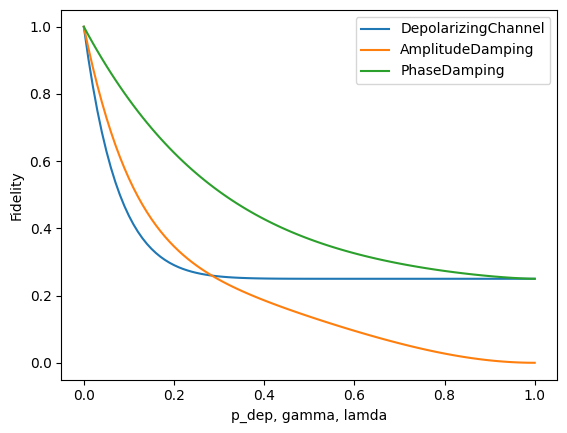

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def idx(a,b,c,d): return (a<<3)|(b<<2)|(c<<1)|d  # (A,B,C,D)->0..15

def ad_rho_given_BC00(rho):
    # ΠρΠ에서 BC=00 성분만 추출
    tilde = np.zeros((16,16), dtype=complex)
    for a in [0,1]:
        for d in [0,1]:
            for ap in [0,1]:
                for dp in [0,1]:
                    i = idx(a,0,0,d)
                    j = idx(ap,0,0,dp)
                    tilde[i,j] = rho[i,j]
    p00 = np.trace(tilde).real
    rho_AD = np.zeros((4,4), dtype=complex)
    for a in [0,1]:
        for d in [0,1]:
            for ap in [0,1]:
                for dp in [0,1]:
                    i = idx(a,0,0,d)
                    j = idx(ap,0,0,dp)
                    rho_AD[(a<<1)|d, (ap<<1)|dp] = tilde[i,j]
    rho_AD /= p00
    return p00, rho_AD

def fidelity(rho, phi):
    phi = phi.reshape(-1)              # (4,) 모양 벡터
    phi = phi / np.linalg.norm(phi)    # 정규화
    return np.real(np.vdot(phi, rho @ phi))


# 예시
_idx = [i/100 for i in range(101)]
F_p = []
F_g = []
F_l = []
for k in _idx:
    rho4 = noisy_circuit(p_dep = k, gamma = 0, lam = 0)
    p00, rho_AD = ad_rho_given_BC00(rho4)
    F_p.append(fidelity(rho_AD, phi_AD))

    rho4 = noisy_circuit(p_dep = 0, gamma = k, lam = 0)
    p00, rho_AD = ad_rho_given_BC00(rho4)
    F_g.append(fidelity(rho_AD, phi_AD))

    rho4 = noisy_circuit(p_dep = 0, gamma = 0, lam = k)
    p00, rho_AD = ad_rho_given_BC00(rho4)
    F_l.append(fidelity(rho_AD, phi_AD))

plt.plot(_idx, F_p)
plt.plot(_idx, F_g)
plt.plot(_idx, F_l)
plt.xlabel("p_dep, gamma, lamda")
plt.ylabel("Fidelity")
plt.legend(["DepolarizingChannel", "AmplitudeDamping", "PhaseDamping"])